Ornstein-Uhlenbeck Process

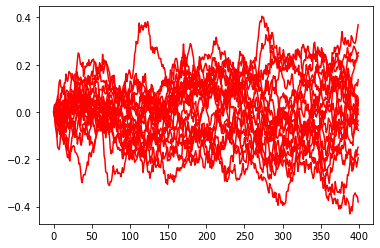

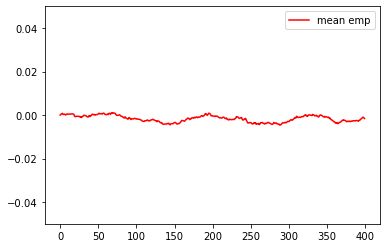

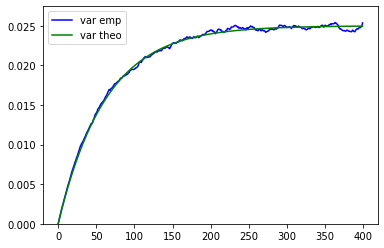

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

T = 4.0
nb_simu = 4000
nb_time = 400
delta = 20
nb_t_support = 20
nu = .2
Y0 = .0
dt = T / float(nb_time)
dt_sqrt = math.sqrt(dt)
dW_t = np.random.normal(size=(nb_simu,nb_time)) * dt_sqrt
beta = 0.8

Y = np.zeros((nb_simu, nb_time))
t = np.arange(0, T, dt)

for i in range(0, nb_simu):
    Y[i][0] = Y0
  
for i in range(0, nb_simu):
    for j in range(1, nb_time):
        Y[i][j] = Y[i][j-1] - beta * Y[i][j-1] * dt + nu * dW_t[i, j]
        
for i in range(0, 20):
    plt.plot(Y[i], color='red')
    
plt.show()

mean_emp = np.zeros((nb_time))
var_emp = np.zeros((nb_time))

var_theo = nu * nu / (2.0 * beta) * (1.0 - np.exp(- 2.0 * beta * t))

for i in range(0, nb_time):
    mean_emp[i] = np.mean(Y[:,i])
    var_emp[i] = np.var(Y[:,i])
    
plt.plot(mean_emp, color='red', label='mean emp')
plt.legend()
plt.ylim(-0.05, 0.05)
plt.show()

plt.plot(var_emp, color='blue', label='var emp')
plt.plot(var_theo, color='green', label='var theo')
plt.legend()
plt.ylim(0, 1.1 * max(var_theo))
plt.show()

Determine eigenvalues and eigenvectors

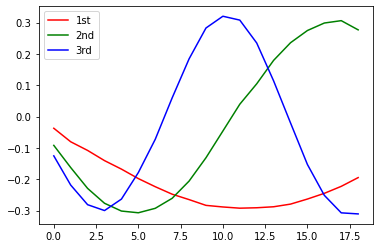

In [3]:
V = np.zeros((nb_simu,nb_t_support-1))
for i_t in range(1, nb_t_support):
    V[:,i_t-1] = Y[:,i_t*delta]

cov = np.cov(V.T)

from numpy import linalg

eigen_values, eigen_vectors = linalg.eig(cov)

eigen = [(eigen_value, eigen_vectors[:,i]) for i, eigen_value in enumerate(eigen_values)]
eigen.sort(key=lambda pair: pair[0], reverse=True)

eigen_values, eigen_vectors = np.array([_eigen[0] for _eigen in eigen]), np.array([_eigen[1] for _eigen in eigen])

A = eigen_vectors

basis_new = [a for a in A]

plt.plot(basis_new[0], color='red', label='1st')
plt.plot(basis_new[1], color='green', label='2nd') 
plt.plot(basis_new[2], color='blue', label='3rd') 
plt.legend()
plt.show()


In [4]:
V_tilde = np.zeros((nb_simu,nb_t_support-1))

for i, v in enumerate(V):
    V_tilde[i] = A.dot(v)

Cross check: Are V_tilde uncorrelated and is there variance given by the eigenvalues?

In [5]:
cov_tilde = np.cov(V_tilde.T)

for i in range(0, nb_t_support-1):
    for j in range(0, nb_t_support-1):
        if i == j:
            #print(cov_tilde[i,j], eigen_values[i])
            assert abs(cov_tilde[i,j] - eigen_values[i]) < 1e-10, 'Deviation too big!'
        elif i < j:
            #print(cov_tilde[i,j])
            assert abs(cov_tilde[i,j]) < 1e-10, 'Deviation too big!'
        else:
            continue
        

Determine how many eigen vectors we need to explain 95% of the stochastic movement

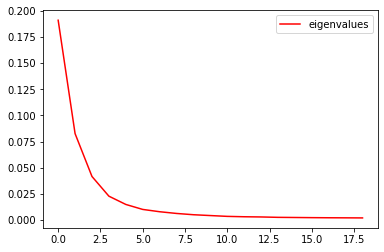

11
17
18


In [6]:
plt.plot(eigen_values, color='red', label='eigenvalues')
plt.legend()
plt.show()

def determine_factors(percentage):
    sum_var = eigen_values.sum()

    s = 0
    for i, eigen_value in enumerate(eigen_values):
        if s < percentage * sum_var:
            s += eigen_value
        else:
            break
            
    return i
 
nb_factors_95 = determine_factors(.95)
print(nb_factors_95)

nb_factors_99 = determine_factors(.99)
print(nb_factors_99)

nb_factors_999 = determine_factors(.999)
print(nb_factors_999)

19


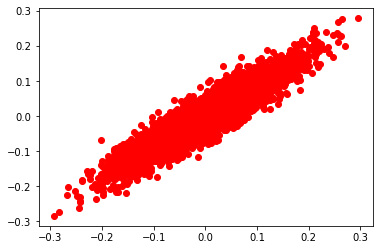

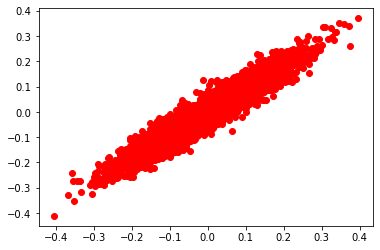

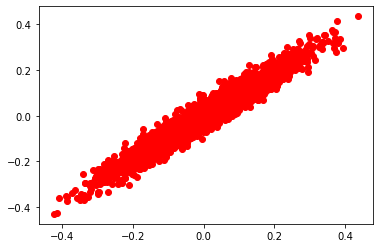

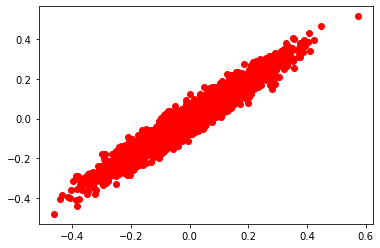

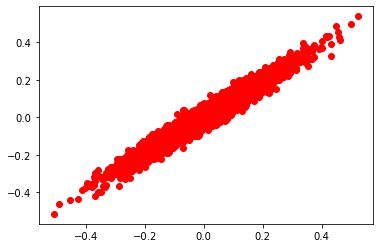

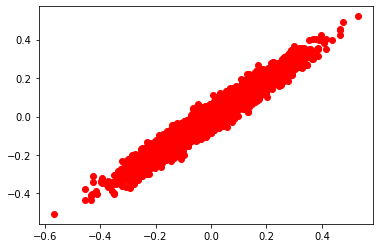

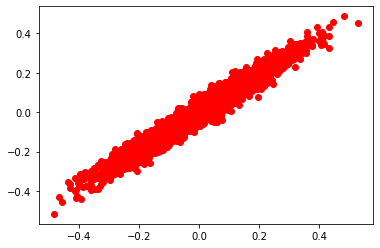

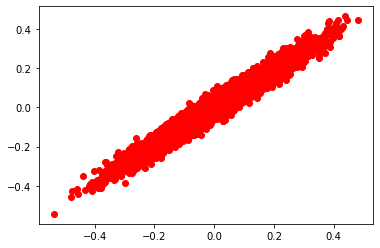

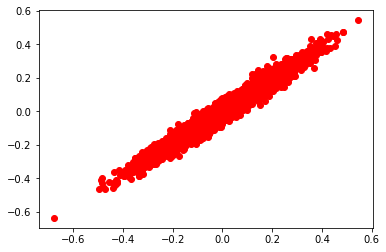

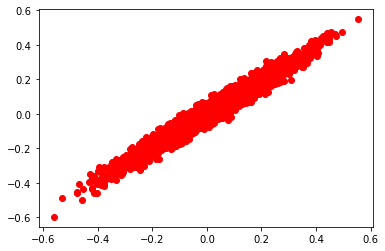

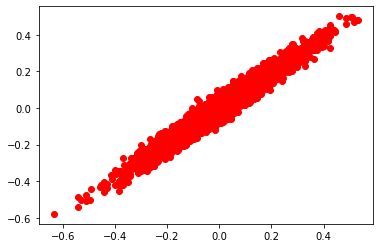

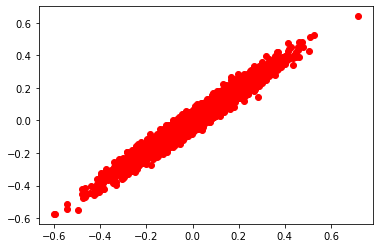

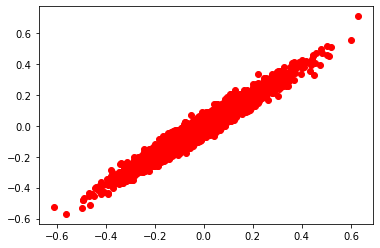

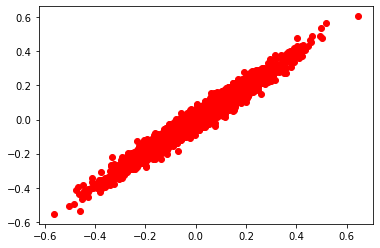

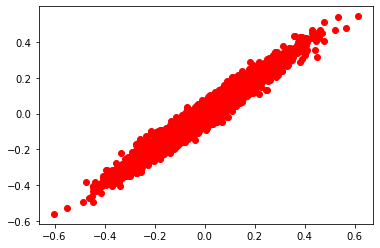

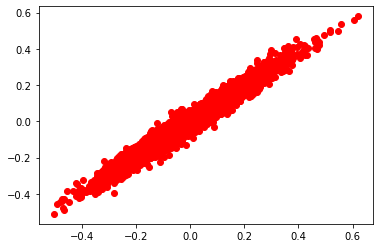

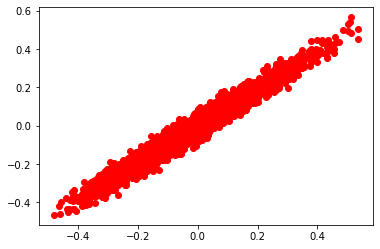

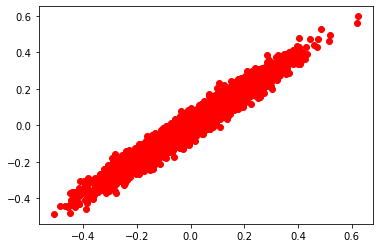

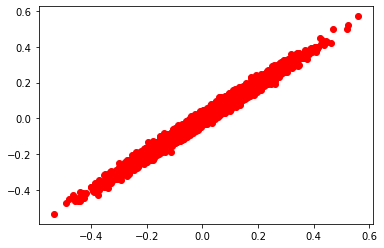

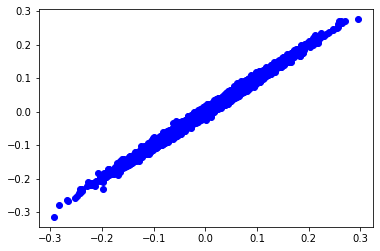

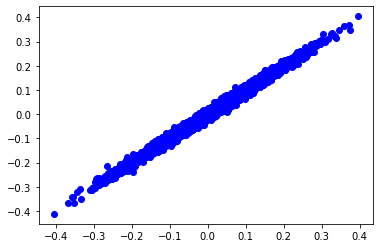

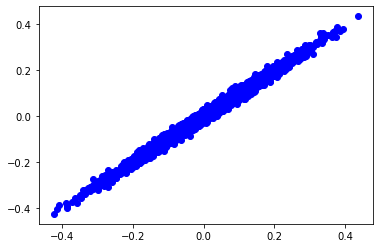

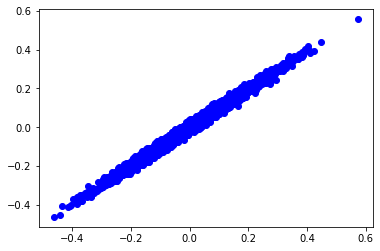

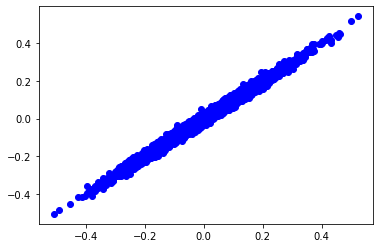

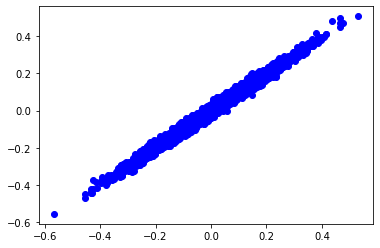

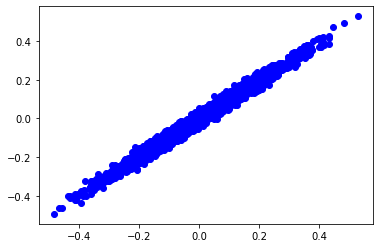

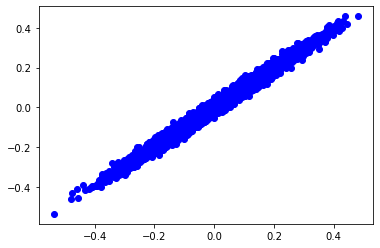

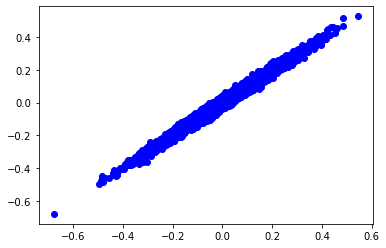

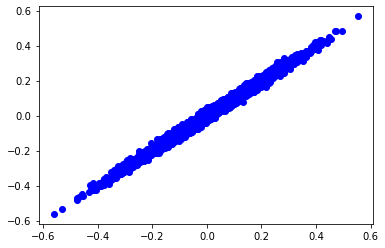

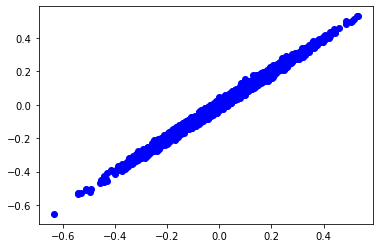

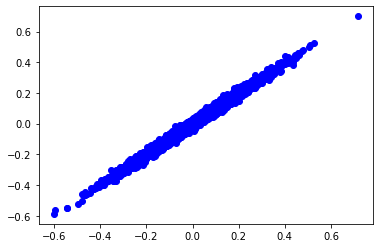

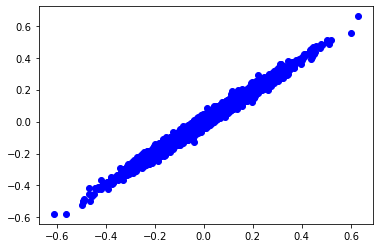

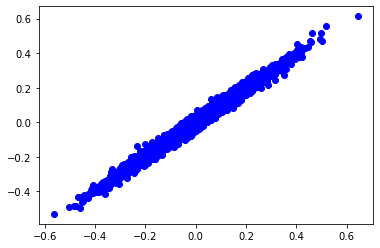

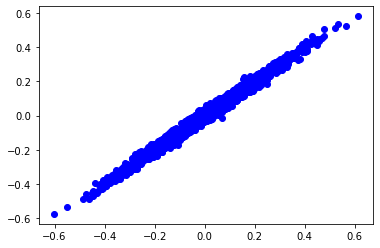

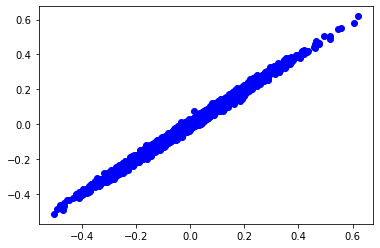

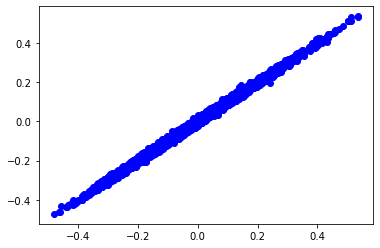

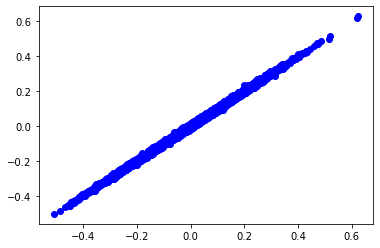

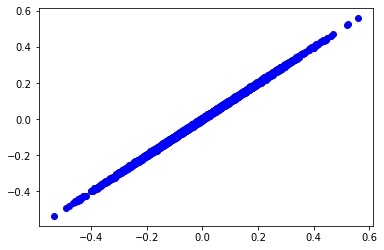

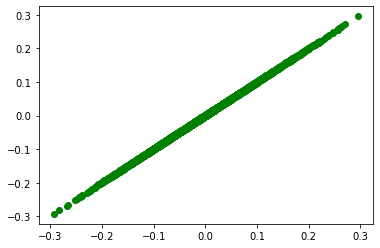

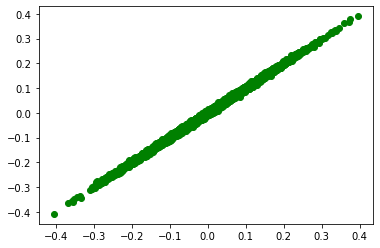

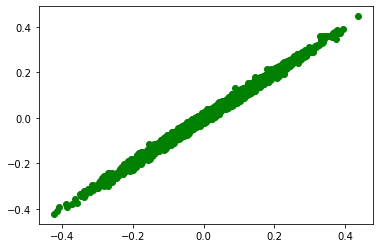

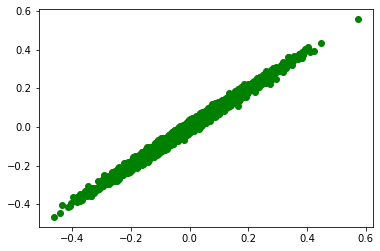

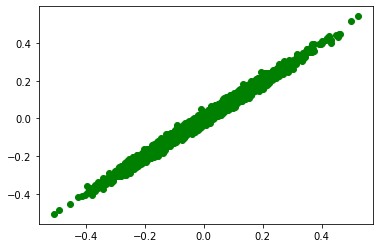

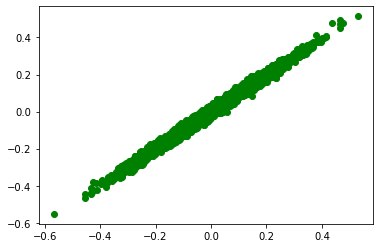

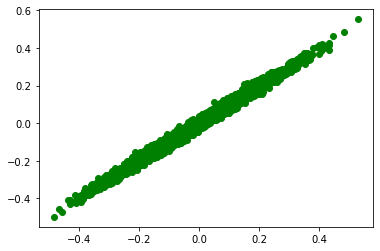

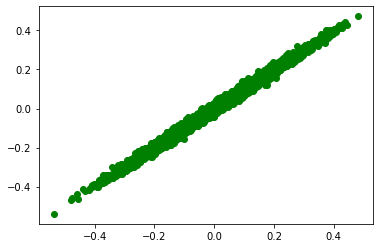

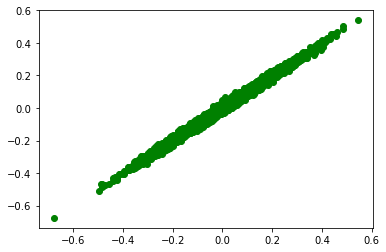

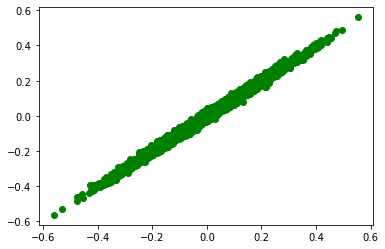

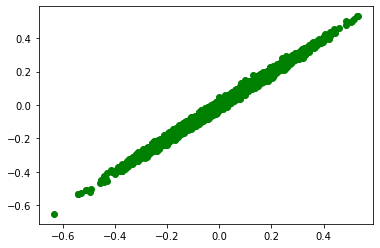

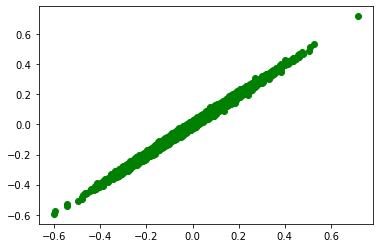

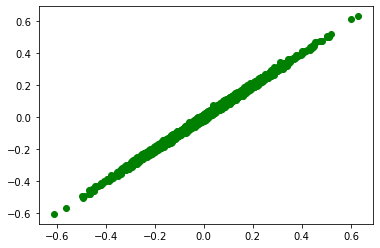

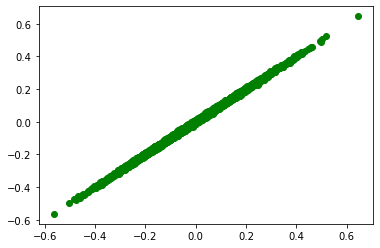

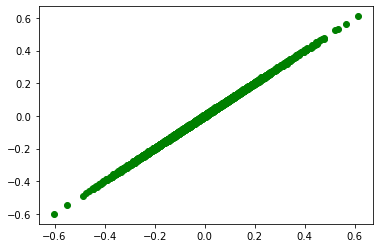

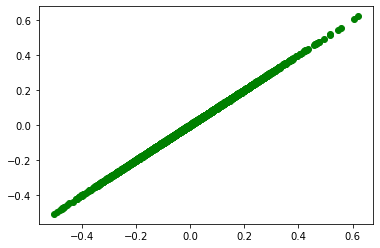

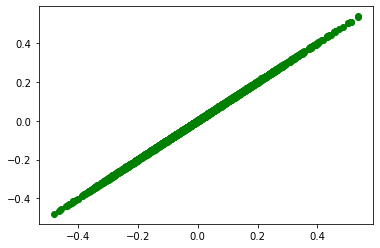

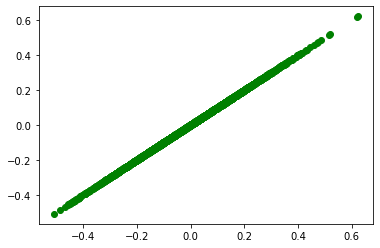

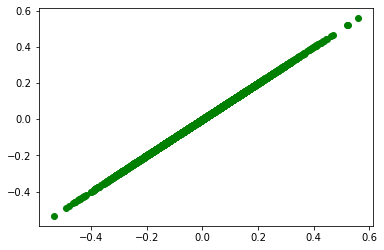

In [7]:
class Proj:
    def __init__(self, A):
        self._A = A

    def __call__(self, v, factors):
        A_reduced = np.zeros((factors,nb_t_support-1))
        
        for i in range(0,factors):
            A_reduced[i] = self._A[i]

        return A_reduced.T.dot(A_reduced).dot(v)

proj = Proj(A)

all_factors = len(V[0])
print(all_factors)

for v in V:
    v_proj = proj(v, all_factors)
    assert linalg.norm(v_proj - v) < 1e-10, 'Deviation too big!'
    
V_95 = np.array([proj(v, nb_factors_95) for v in V])
V_99 = np.array([proj(v, nb_factors_99) for v in V])
V_999 = np.array([proj(v, nb_factors_999) for v in V])

for i_t in range(0, nb_t_support-1):
    plt.scatter(V[:,i_t], V_95[:,i_t], color='red')
    plt.show()
    
for i_t in range(0, nb_t_support-1):
    plt.scatter(V[:,i_t], V_99[:,i_t], color='blue')
    plt.show()
    
for i_t in range(0, nb_t_support-1):
    plt.scatter(V[:,i_t], V_999[:,i_t], color='green')
    plt.show()

Compute first moments

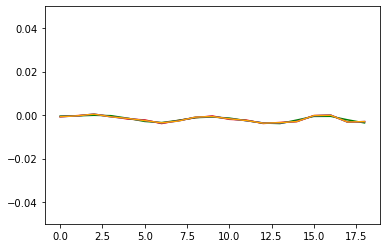

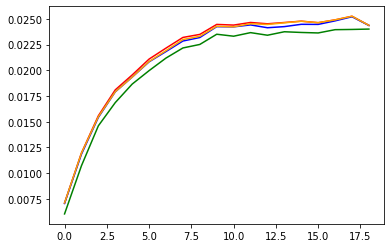

In [8]:
exp_orig = [np.mean(V[:,i_t]) for i_t in range(0, nb_t_support-1)]
exp_95 = [np.mean(V_95[:,i_t]) for i_t in range(0, nb_t_support-1)]
exp_99 = [np.mean(V_99[:,i_t]) for i_t in range(0, nb_t_support-1)]
exp_999 = [np.mean(V_999[:,i_t]) for i_t in range(0, nb_t_support-1)]

var_orig = [np.var(V[:,i_t]) for i_t in range(0, nb_t_support-1)]
var_95 = [np.var(V_95[:,i_t]) for i_t in range(0, nb_t_support-1)]
var_99 = [np.var(V_99[:,i_t]) for i_t in range(0, nb_t_support-1)]
var_999 = [np.var(V_999[:,i_t]) for i_t in range(0, nb_t_support-1)]

plt.plot(exp_orig, color='red', label='original')
plt.plot(exp_95, color='green', label='95%')
plt.plot(exp_99, color='blue', label='99%')
plt.plot(exp_999, color='orange', label='99.9%')
plt.ylim(-0.05, 0.05)
plt.show()

plt.plot(var_orig, color='red', label='original')
plt.plot(var_95, color='green', label='95%')
plt.plot(var_99, color='blue', label='99%')
plt.plot(var_999, color='orange', label='99.9%')
plt.show()

Set up Autoencoder Neural Network

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 11)                220       
_________________________________________________________________
dense_58 (Dense)             (None, 19)                228       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5000
2/2 [==============================] - 1s 314ms/step - loss: 0.0359 - mse: 0.0359 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 2/5000
2/2 [==============================] - 0s 106ms/step - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0364 - val_mse: 0.0364
Epoch 3/5000
2/2 [==============================] - 0s 109ms/step - loss: 0.0346 - mse: 0.0346 - val_loss: 0.0358 - val_mse: 0.0358
Epoch 4/5000
2/2 [==============================] - 0s 108ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.0351 - 

2/2 [==============================] - 0s 124ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 59/5000
2/2 [==============================] - 0s 131ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 60/5000
2/2 [==============================] - 0s 91ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 61/5000
2/2 [==============================] - 0s 121ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 62/5000
2/2 [==============================] - 0s 186ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 63/5000
2/2 [==============================] - 0s 105ms/step - loss: 0.0134 - mse: 0.0134 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 64/5000
2/2 [==============================] - 0s 104ms/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 65/5000
2/2 [==============================] - 0s 134ms/step - loss: 0.0130 - 

Epoch 120/5000
2/2 [==============================] - 0s 211ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 121/5000
2/2 [==============================] - 0s 117ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0046 - val_mse: 0.0046
Epoch 122/5000
2/2 [==============================] - 0s 86ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 123/5000
2/2 [==============================] - 0s 79ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 124/5000
2/2 [==============================] - 0s 73ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 125/5000
2/2 [==============================] - 0s 53ms/step - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 126/5000
2/2 [==============================] - 0s 58ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 127/5000
2/2 [==============================] - 0s 57ms/step 

2/2 [==============================] - 0s 28ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 182/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 183/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 184/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 185/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 186/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 187/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0025
Epoch 188/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0024 - 

Epoch 243/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 244/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 245/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 246/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 247/5000
2/2 [==============================] - ETA: 0s - loss: 0.0019 - mse: 0.001 - 0s 29ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 248/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0019 - mse: 0.0019 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 249/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 250/5000
2/2 [===========

2/2 [==============================] - 0s 47ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 305/5000
2/2 [==============================] - 0s 41ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 306/5000
2/2 [==============================] - 0s 33ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 307/5000
2/2 [==============================] - 0s 33ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 308/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 309/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 310/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 311/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0015 - 

Epoch 366/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 367/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 368/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 369/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 370/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 371/5000
2/2 [==============================] - 0s 33ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 372/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 373/5000
2/2 [==============================] - 0s 25ms/step - 

2/2 [==============================] - 0s 23ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 428/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 429/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 430/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 431/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 432/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 433/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 434/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0013 - 

Epoch 489/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 490/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 491/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 492/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 493/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 494/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 495/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 496/5000
2/2 [==============================] - 0s 25ms/step - 

2/2 [==============================] - 0s 28ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 551/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 552/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 553/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 554/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 555/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 556/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 557/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - 

Epoch 612/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 613/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 614/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 615/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 616/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 617/5000
2/2 [==============================] - 0s 29ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 618/5000
2/2 [==============================] - 0s 29ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 619/5000
2/2 [==============================] - 0s 29ms/step - 

2/2 [==============================] - 0s 25ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 674/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 675/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 676/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 677/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 678/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 679/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 680/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0011 - 

Epoch 735/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 736/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 737/5000
2/2 [==============================] - 0s 28ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 738/5000
2/2 [==============================] - 0s 40ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 739/5000
2/2 [==============================] - 0s 46ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 740/5000
2/2 [==============================] - 0s 37ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 741/5000
2/2 [==============================] - 0s 31ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 742/5000
2/2 [==============================] - 0s 31ms/step - 

2/2 [==============================] - 0s 23ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 797/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 798/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 799/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 800/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 801/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 802/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 803/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0011 - 

Epoch 858/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 859/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 860/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 861/5000
2/2 [==============================] - 0s 35ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 862/5000
2/2 [==============================] - 0s 34ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 863/5000
2/2 [==============================] - 0s 36ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 864/5000
2/2 [==============================] - 0s 39ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 865/5000
2/2 [==============================] - 0s 40ms/step - 

2/2 [==============================] - 0s 23ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 920/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 921/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 922/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 923/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 924/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 925/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 926/5000
2/2 [==============================] - 0s 97ms/step - loss: 0.0011 - 

Epoch 981/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 982/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 983/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 984/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 985/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 986/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 987/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 988/5000
2/2 [==============================] - 0s 21ms/step - 

2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1043/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1044/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1045/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1046/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1047/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1048/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1049/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.

2/2 [==============================] - 0s 26ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1104/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1105/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1106/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1107/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1108/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1109/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1110/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1165/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1166/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1167/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1168/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1169/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1170/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1171/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.

2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1226/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1227/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1228/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1229/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1230/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1231/5000
2/2 [==============================] - 0s 20ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1232/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.

2/2 [==============================] - 0s 24ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1287/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1288/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1289/5000
2/2 [==============================] - 0s 25ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1290/5000
2/2 [==============================] - 0s 21ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1291/5000
2/2 [==============================] - 0s 22ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1292/5000
2/2 [==============================] - 0s 23ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1293/5000
2/2 [==============================] - 0s 24ms/step - loss: 0.

2/2 [==============================] - 0s 26ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1348/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1349/5000
2/2 [==============================] - 0s 35ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1350/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1351/5000
2/2 [==============================] - 0s 34ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1352/5000
2/2 [==============================] - 0s 31ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1353/5000
2/2 [==============================] - 0s 30ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1354/5000
2/2 [==============================] - 0s 36ms/step - loss: 0.

2/2 [==============================] - 0s 28ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1409/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1410/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1411/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1412/5000
2/2 [==============================] - 0s 33ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1413/5000
2/2 [==============================] - 0s 26ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1414/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.0010 - mse: 0.0010 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 1415/5000
2/2 [==============================] - 0s 27ms/step - loss: 0.

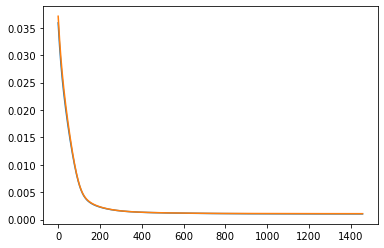

(11, 19)
(19, 11)
[[ 9.99985278e-01  3.80436613e-05  7.21811193e-06 -1.31486622e-05
   5.56379564e-06  2.98398314e-04 -3.81552265e-04  6.05082932e-05
  -5.13669453e-04 -9.37983394e-04  2.12948001e-03  1.23773294e-03
  -7.46649923e-04 -1.90216734e-03  5.62608300e-04 -1.50996319e-03
   1.28842657e-04  2.00822949e-03 -2.38467488e-04]
 [ 7.64369531e-07  1.00000954e+00 -2.30461046e-05 -6.06271215e-07
   2.46661366e-05  4.68563987e-04 -7.26615872e-06 -1.67368926e-04
   2.35662956e-05 -2.46739437e-05  7.03901518e-04 -5.01933857e-04
   3.49976035e-04 -5.89253905e-04 -1.24872988e-03 -9.55304597e-04
   3.46886547e-04  1.76865331e-04 -3.35384277e-04]
 [-2.38978555e-05 -1.75727291e-05  1.00000238e+00  1.02643517e-05
  -4.73908876e-05 -4.12679190e-04  1.29322245e-04 -2.15695065e-04
   1.00232183e-03  2.22244696e-03 -2.60819774e-03 -5.53077494e-04
  -2.72468489e-04  2.34938855e-03  1.56903174e-03 -2.88629020e-03
  -8.98710685e-04  6.92629081e-04  1.62627752e-04]
 [-2.07372577e-05 -4.50826992e-05  2.

In [40]:
dim_input = len(V[0])
dim_output = dim_input
dim_encoding = 11

from keras.models import Sequential 
from keras.layers import Activation, Dense 
from keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping

def reduce_dimension(V):
    autoencoder = Sequential()
    encoded = Dense(dim_encoding, activation='linear', input_shape=(dim_input,))
    autoencoder.add(encoded)
    decoded = Dense(dim_output, activation='linear')
    autoencoder.add(decoded)

    autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
    print(autoencoder.summary())

    early_stopping = EarlyStopping(monitor='mse', min_delta=1e-12, patience=3, verbose=0)

    history = autoencoder.fit(V, V,
                    epochs=5000,
                    batch_size=2000,
                    shuffle=True,
                    validation_split=0.1,
                    verbose = 1,
                    callbacks=[early_stopping])

    #plot our loss 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    weights_encoded = encoded.trainable_weights
    a_encoded, B_encoded = weights_encoded[1].numpy(), weights_encoded[0].numpy().T
    print(B_encoded.shape)

    weights_decoded = decoded.trainable_weights
    a_decoded, B_decoded = weights_decoded[1].numpy(), weights_decoded[0].numpy().T
    print(B_decoded.shape)

    proj_ml = B_decoded.dot(B_encoded)

    return proj_ml, a_encoded, B_encoded, a_decoded, B_decoded


#proj_ml_V, a_encoded_V, B_encoded_V, a_decoded_V, B_decoded_V = reduce_dimension(V)

proj_ml_V_tilde, a_encoded_V_tilde, B_encoded_V_tilde, a_decoded_V_tilde, B_decoded_V_tilde = reduce_dimension(V_tilde)
print(proj_ml_V_tilde)
